# Which Asset Class is safe against unexpected inflation?

This notebook attempts to duplicate this analysis by prof. Damodaran:

[Inflation and Investing: False Alarm or Fair Warning?](https://www.youtube.com/watch?v=p0vqmjgF3E4)

I thought it might be interesting to be able to get the latest data whenever we need to perform this analysis in the future.

Data source locations:

- Inflation: https://www.quandl.com/data/RATEINF/CPI_USA-Consumer-Price-Index-USA
- T-Bond: [Damodaran Online: Historical Returns on Stocks, Bonds and Bills](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html) (I could not find a larger data source than the one in prof. Damodaran's website so I used it)
- S&P 500 and Real Estate: [ONLINE DATA ROBERT SHILLER](http://www.econ.yale.edu/~shiller/data.htm) (Much thanks to Prof. Robert J. Shiller for providing this dataset)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd, YearEnd, YearBegin

import matplotlib.dates as mdates
import matplotlib.ticker as mtick

INFLATION_DATA = 'data/inflation.csv'
TBOND_DATA = 'data/histretSP.xls'
SP500_DATA = 'data/sp500.xls'
GOLD_DATA = 'data/gold.xlsx'
REAL_ESTATE_DATA = 'data/real_estate.xls'

## 1. Prepare Expected and Unexpected Inflation Rates

In [2]:
inf = pd.read_csv(INFLATION_DATA)
inf = inf.rename(columns={'Date': 'date', 'Value': 'value'})
inf['date'] = pd.to_datetime(inf['date'])
inf.set_index('date', inplace=True)
inf['value'] = inf['value'] / 100
inf = inf.groupby(pd.Grouper(freq="Y")).value.mean().to_frame(name='actual_inflation')

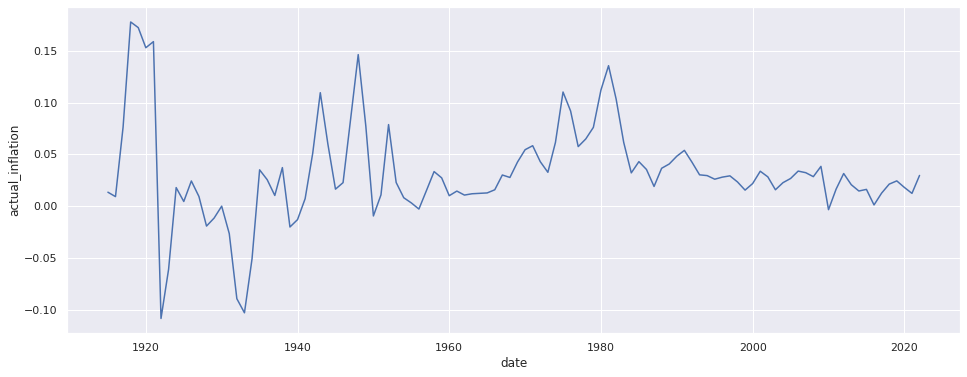

In [3]:
plt.figure(figsize=(16, 6))
sns.set_theme()
sns.lineplot(data=inf, x=inf.index, y="actual_inflation");

In [4]:
inf.index

DatetimeIndex(['1914-12-31', '1915-12-31', '1916-12-31', '1917-12-31',
               '1918-12-31', '1919-12-31', '1920-12-31', '1921-12-31',
               '1922-12-31', '1923-12-31',
               ...
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31',
               '2020-12-31', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=108, freq='A-DEC')

In [5]:
inf = inf.sort_values(by='date')
inf['avg_past_10y'] = inf['actual_inflation'].rolling(10).mean()
inf['unexpected_inflation'] = inf['actual_inflation'] - inf['avg_past_10y']

# Unexpected inflation is a hindsight measurement, so if we have calculated for
# year 1947, for example, then the result is stored for year 1946.
inf['unexpected_inflation'] = inf['unexpected_inflation'].shift(-1)
# inf = inf.dropna()
inf

,actual_inflation,avg_past_10y,unexpected_inflation
date,,,
1914-12-31,0.013494,NaN,NaN
1915-12-31,0.009234,NaN,NaN
1916-12-31,0.076426,NaN,NaN
1917-12-31,0.178002,NaN,NaN
1918-12-31,0.172546,NaN,NaN
...,...,...,...
2017-12-31,0.021301,0.016981,0.008850
2018-12-31,0.024428,0.015578,0.000389
2019-12-31,0.018117,0.017727,-0.004953


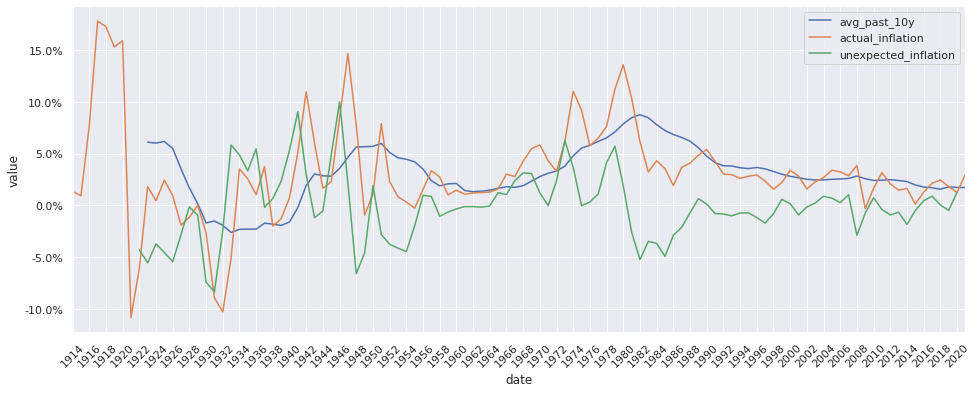

In [6]:
def plot_multilines(df, x, Y):
    df_plot = df.reset_index()[[x]+Y]
    df_plot[x] = df_plot[x] - YearBegin(1)
    df_plot = df_plot.melt(x, var_name='cols', value_name='vals')
    plt.figure(figsize=(16, 6))
    sns.set_theme()
    ax = sns.lineplot(x=x, y='vals', hue='cols', data=df_plot)
    return ax
    
def style(ax, labels=None, year_gap=2):
    ax.xaxis.set_major_locator(mdates.YearLocator(year_gap))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.margins(x=0)
    ax.set(ylabel="value")
    ax.legend(title="")
    if labels != None:
        legend = ax.legend()
        for i, l in enumerate(labels):
            legend.texts[i].set_text(l)
    return plt.xticks(rotation=45)

ax = plot_multilines(inf, 'date', ['avg_past_10y', 'actual_inflation', 'unexpected_inflation'])
ax = style(ax);

## 2. T-Bond

In [7]:
tbond = pd.read_excel(TBOND_DATA,
                      sheet_name="S&P 500 & Raw Data",
                      skiprows=list(range(0,1)))
tbond = tbond[['Year', 'Return on bond']]
tbond = tbond.rename(columns={'Year': 'date', 'Return on bond': 'yield'})
tbond['date'] = pd.to_datetime(tbond['date'], format='%Y') + YearEnd(1)
tbond = tbond.set_index('date')
tbond = tbond.dropna()

In [8]:
tbond.head(5)

,yield
date,
1928-12-31,0.008355
1929-12-31,0.042038
1930-12-31,0.045409
1931-12-31,-0.025589
1932-12-31,0.087903


In [9]:
combined1 = pd.merge(inf, tbond, left_on='date', right_on='date', how='left')
combined1 = combined1.rename(columns={'yield': 'tbond'})
combined1 = combined1[['actual_inflation', 'unexpected_inflation', 'tbond']]

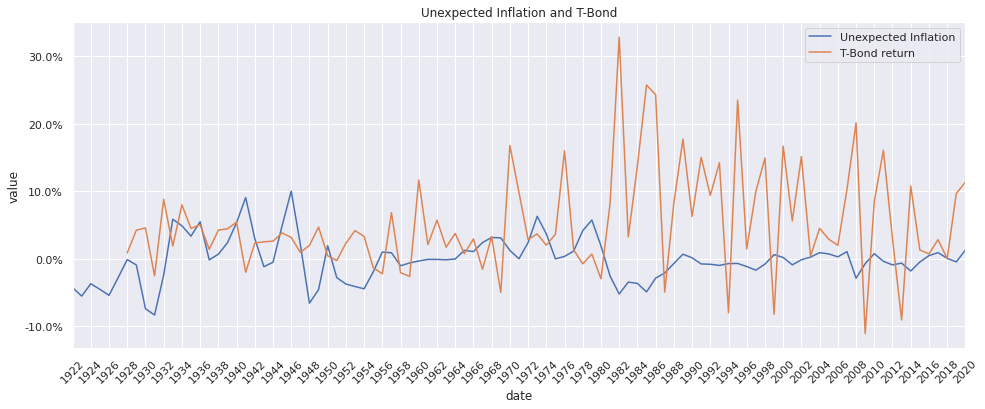

In [10]:
ax = plot_multilines(combined1, 'date', ['unexpected_inflation', 'tbond'])
style(ax, ["Unexpected Inflation", "T-Bond return"])
ax.set_title("Unexpected Inflation and T-Bond");

## 3. S&P 500 Index

In [11]:
sp500 = pd.read_excel(SP500_DATA,
                      sheet_name="Data",
                      skiprows=list(range(0,7))
                      )
sp500 = sp500.iloc[:-1, :3]
sp500 = sp500.rename(columns={'Date': 'date', 'P': 'price', 'D': 'dividend'})

# 1871.1 to 1871.10
sp500['date'] = sp500['date'].apply(lambda x: '{0:.2f}'.format(x))

sp500['date'] = sp500['date'].astype(str)
sp500['price'] = sp500['price'].astype(float)
sp500['date'] = pd.to_datetime(sp500['date'], format="%Y.%m")
sp500['date'] = sp500['date'] + MonthEnd(1)
sp500.set_index('date', inplace=True)

In [12]:
def get_total_dividends(df):
    g = df.groupby(pd.Grouper(freq="Q-DEC"))
    g = g.last().groupby(pd.Grouper(freq="Y")).sum()
    g = g['dividend']
    return g

def get_earnings_plus_dividends_yoy(df, dividends):
    g = df.groupby(pd.Grouper(freq="Y"))
    prev_dividends = dividends.shift(1)
    firstp = g.price.last().shift(1)
    firstp_div = firstp + prev_dividends
    lastp = g.price.last()
    lastp_div = lastp + dividends
    comb = firstp.to_frame(name='first') \
           .join(lastp.to_frame(name='last')) \
           .join(dividends.to_frame(name='dividends')) \
           .join(lastp_div.to_frame(name='last_plus_dividends'))
    comb['yoy_change'] = (comb['last_plus_dividends'] / comb['first']) - 1
#     comb['earnings'] = g.earnings_default.last()
    return comb
divs = get_total_dividends(sp500)
sp500g = get_earnings_plus_dividends_yoy(sp500, divs)
sp500g = sp500g[sp500g.index.year >= inf.index[0].year]
sp500g

,first,last,dividends,last_plus_dividends,yoy_change
date,,,,,
1914-12-31,8.040000,7.350000,1.770000,9.120000,0.134328
1915-12-31,7.350000,9.480000,1.705000,11.185000,0.521769
1916-12-31,9.480000,9.800000,2.045000,11.845000,0.249473
1917-12-31,9.800000,6.800000,2.565000,9.365000,-0.044388
1918-12-31,6.800000,7.900000,2.460000,10.360000,0.523529
...,...,...,...,...,...
2017-12-31,2246.630000,2664.340000,190.700000,2855.040000,0.270810
2018-12-31,2664.340000,2567.310000,207.080000,2774.390000,0.041305
2019-12-31,2567.310000,3176.749524,226.477275,3403.226799,0.325600


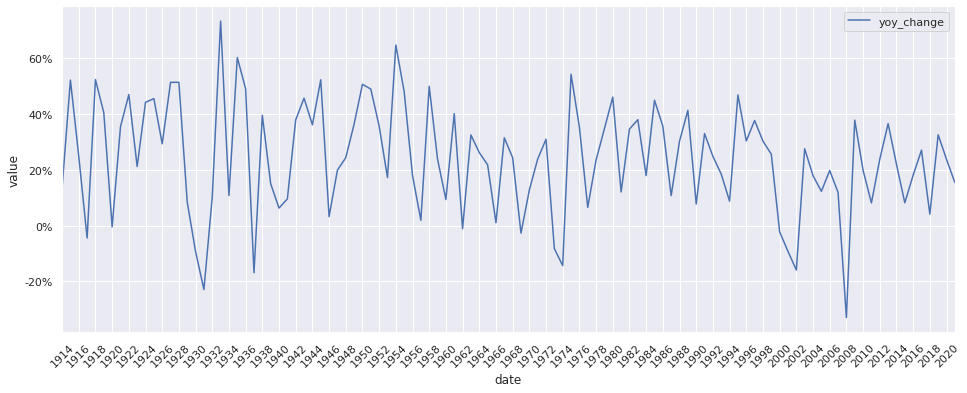

In [13]:
ax = plot_multilines(sp500g, 'date', ['yoy_change'])
style(ax);

### Merging unexpected inflation + S&P 500 Index

In [14]:
combined2 = pd.merge(combined1, sp500g, left_on='date', right_on='date', how='left')
combined2 = combined2.rename(columns={'yoy_change': 'sp500'})
combined2 = combined2[['actual_inflation', 'unexpected_inflation', 'tbond', 'sp500']]

In [15]:
combined2

,actual_inflation,unexpected_inflation,tbond,sp500
date,,,,
1914-12-31,0.013494,NaN,NaN,0.134328
1915-12-31,0.009234,NaN,NaN,0.521769
1916-12-31,0.076426,NaN,NaN,0.249473
1917-12-31,0.178002,NaN,NaN,-0.044388
1918-12-31,0.172546,NaN,NaN,0.523529
...,...,...,...,...
2017-12-31,0.021301,0.008850,0.028017,0.270810
2018-12-31,0.024428,0.000389,-0.000167,0.041305
2019-12-31,0.018117,-0.004953,0.096356,0.325600


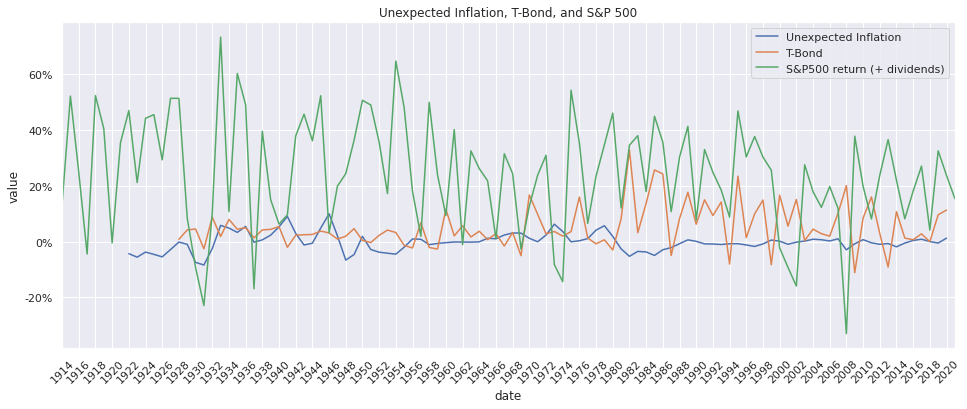

In [16]:
ax = plot_multilines(combined2, 'date', ['unexpected_inflation', 'tbond', 'sp500'])
style(ax, ["Unexpected Inflation", "T-Bond", "S&P500 return (+ dividends)"])
ax.set_title("Unexpected Inflation, T-Bond, and S&P 500");

## 4. Gold

In [17]:
gold = pd.read_excel(GOLD_DATA,
                     sheet_name="Annual_EndofPeriod",
                     skiprows=list(range(0,9)),
                     header=None,
                     engine="openpyxl")
gold = gold.iloc[:, 3:5]
gold = gold.rename(columns={3: 'date', 4: 'price'})
gold['date'] = pd.to_datetime(gold['date'], format='%Y') + YearEnd(1)
gold = gold.set_index('date')
gold['firstp'] = gold['price'].shift(1)
gold['yoy_change'] = (gold['price'] / gold['firstp']) - 1

In [18]:
gold.head(5)

,price,firstp,yoy_change
date,,,
1978-12-31,226.00,NaN,NaN
1979-12-31,512.00,226.00,1.265487
1980-12-31,589.75,512.00,0.151855
1981-12-31,397.50,589.75,-0.325986
1982-12-31,456.90,397.50,0.149434


In [19]:
combined3 = pd.merge(combined2, gold, left_on='date', right_on='date', how='left')
combined3 = combined3.rename(columns={'yoy_change': 'gold'})
combined3 = combined3[['actual_inflation', 'unexpected_inflation', 'tbond', 'sp500', 'gold']]

In [20]:
combined3

,actual_inflation,unexpected_inflation,tbond,sp500,gold
date,,,,,
1914-12-31,0.013494,NaN,NaN,0.134328,NaN
1915-12-31,0.009234,NaN,NaN,0.521769,NaN
1916-12-31,0.076426,NaN,NaN,0.249473,NaN
1917-12-31,0.178002,NaN,NaN,-0.044388,NaN
1918-12-31,0.172546,NaN,NaN,0.523529,NaN
...,...,...,...,...,...
2017-12-31,0.021301,0.008850,0.028017,0.270810,0.126625
2018-12-31,0.024428,0.000389,-0.000167,0.041305,-0.009295
2019-12-31,0.018117,-0.004953,0.096356,0.325600,0.184324


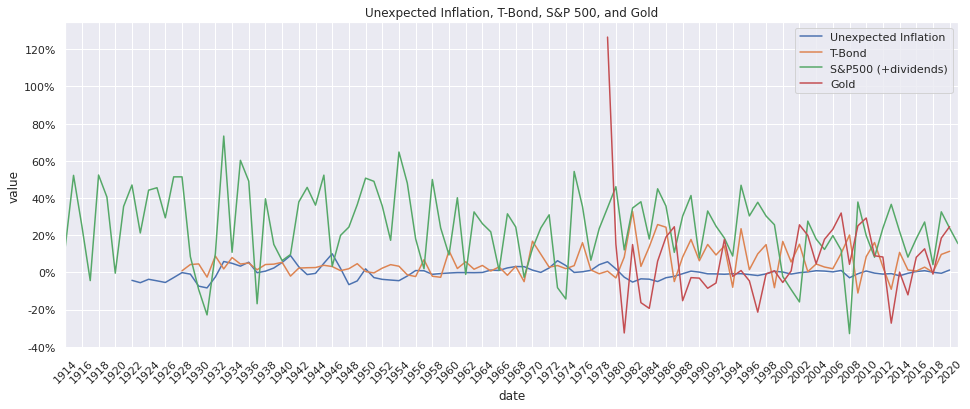

In [21]:
ax = plot_multilines(combined3, 'date', ['unexpected_inflation', 'tbond', 'sp500', 'gold'])
style(ax, ["Unexpected Inflation", "T-Bond", "S&P500 (+dividends)", "Gold"])
ax.set_title("Unexpected Inflation, T-Bond, S&P 500, and Gold");

## 5. Real Estate

In [22]:
real_estate = pd.read_excel(REAL_ESTATE_DATA,
                            sheet_name="Data",
                            skiprows=list(range(0,6)),
                            engine="xlrd")
real_estate = real_estate.rename(columns={'Date': 'year', 'From fig2.1Revised2011.xls': 'index'})
real_estate = real_estate[['year', 'index']]
real_estate = real_estate.dropna()

def impute_values(df, id_field, value_field):
    """ Impute missing values in `df` by looking at id differences.
    
    
    """
    real_estate.loc[real_estate[id_field] % 1 == 0, id_field] = \
        real_estate.loc[real_estate[id_field] % 1 == 0, id_field] + 1
    
    indexes = pd.Index(np.arange(df[id_field].min(), df[id_field].max(), 1))
    df1 = df.set_index(id_field)
    missing_indexes = indexes.difference(df1.index)
    for idx in missing_indexes:
        df1.loc[idx, value_field] = None
    df1 = df1.sort_index()
    df1[value_field] = df1[value_field].interpolate(method='linear')
    df1 = df1.loc[df1.index % 1 == 0].shift(-1)
    return df1

real_estate = impute_values(real_estate, 'year', 'index')

real_estate['date'] = pd.to_datetime(real_estate.index.astype(int), format="%Y") + YearEnd(1)
real_estate = real_estate.set_index('date')
real_estate['prev_index'] = real_estate['index'].shift(1)
real_estate['yoy_change'] = real_estate['index'] / real_estate['prev_index'] - 1
real_estate = real_estate.dropna()
real_estate['yoy_change'] = real_estate['yoy_change'].astype(float)

In [23]:
combined4 = pd.merge(combined3, real_estate, left_on='date', right_on='date')
combined4 = combined4.rename(columns={'yoy_change': 'real_estate'})
combined4 = combined4[['actual_inflation', 'unexpected_inflation', 'tbond', 'sp500', 'gold', 'real_estate']]

In [24]:
combined4

,actual_inflation,unexpected_inflation,tbond,sp500,gold,real_estate
date,,,,,,
1914-12-31,0.013494,NaN,NaN,0.134328,NaN,0.037185
1915-12-31,0.009234,NaN,NaN,0.521769,NaN,-0.081946
1916-12-31,0.076426,NaN,NaN,0.249473,NaN,0.094840
1917-12-31,0.178002,NaN,NaN,-0.044388,NaN,0.020382
1918-12-31,0.172546,NaN,NaN,0.523529,NaN,0.063670
...,...,...,...,...,...,...
2016-12-31,0.012636,0.004320,0.006906,0.180918,0.081038,0.054080
2017-12-31,0.021301,0.008850,0.028017,0.270810,0.126625,0.062114
2018-12-31,0.024428,0.000389,-0.000167,0.041305,-0.009295,0.043357


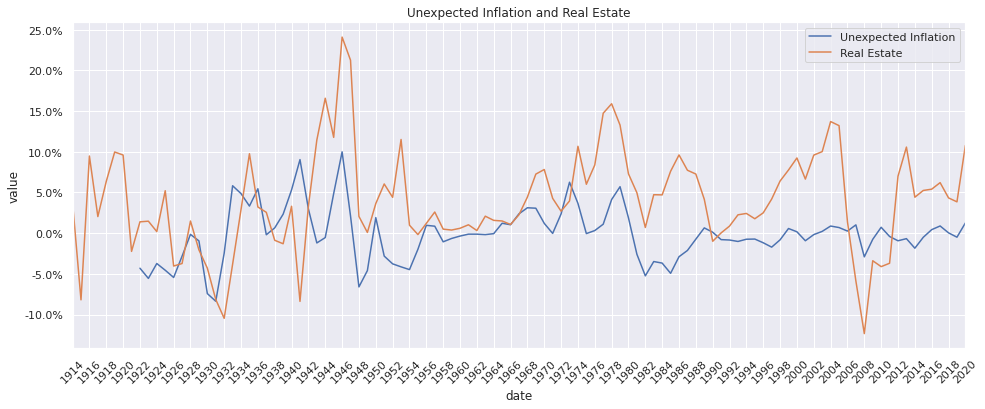

In [25]:
ax = plot_multilines(combined4, 'date', ['unexpected_inflation', 'real_estate'])
style(ax, ["Unexpected Inflation", "Real Estate"])
ax.set_title("Unexpected Inflation and Real Estate");

## 6. Correlation Analysis

In [26]:
corr = combined4[['actual_inflation', 'unexpected_inflation', 'tbond', 'sp500', 'gold', 'real_estate']].corr()
corr

,actual_inflation,unexpected_inflation,tbond,sp500,gold,real_estate
actual_inflation,1.000000,0.337851,0.036066,-0.067791,0.241603,0.486498
unexpected_inflation,0.337851,1.000000,-0.227691,-0.038707,0.575756,0.309312
tbond,0.036066,-0.227691,1.000000,-0.041323,-0.059320,-0.079842
sp500,-0.067791,-0.038707,-0.041323,1.000000,0.040701,0.050887
gold,0.241603,0.575756,-0.059320,0.040701,1.000000,0.128492
real_estate,0.486498,0.309312,-0.079842,0.050887,0.128492,1.000000


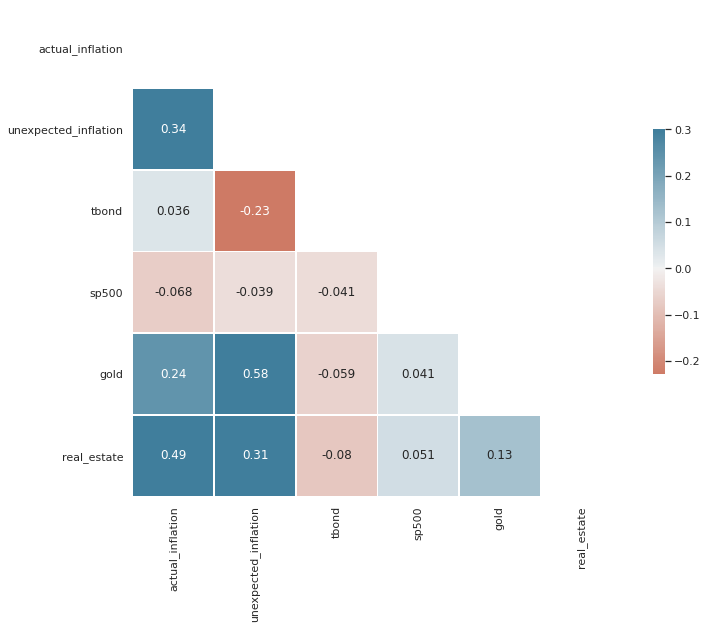

In [27]:
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(20, 230, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True);

### Conclusions

1. Gold and Real estate are a good hedge for inflation.
2. Real estate performed better than gold in an environment with high actual inflation rate.